In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
from jax import lax, vmap
from jax import config
import optax
config.update("jax_enable_x64", True)

import pfjax as pf
import pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def logw_to_prob(logw):
    r"""
    Calculate normalized probabilities from unnormalized log weights.

    Args:
        logw: Vector of `n_particles` unnormalized log-weights.

    Returns:
        Vector of `n_particles` normalized weights that sum to 1.
    """
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    return prob

def resample_custom(key, x_particles_prev, logw):
    r"""
    Particle resampler with Multivariate Normal approximation.

    Args:
        key: PRNG key.
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.

    Returns:
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.
            - `mvn_mean`: Vector of length `n_state = prod(x_particles.shape[1:])` representing the mean of the MVN.
            - `mvn_cov`: Matrix of size `n_state x n_state` representing the covariance matrix of the MVN.
    """
    prob = logw_to_prob(logw)
    
    n_particles = logw.shape[0]
    
    condition = jnp.sum(prob) > 0.
    
    particles_tmp = x_particles_prev[:,-1,0]
    prob_tmp = jnp.where(condition,
                         prob,
                         jnp.array([1./n_particles]*n_particles))
    
    vol_mean = jnp.average(particles_tmp, weights=prob_tmp)
    vol_var = jnp.average((particles_tmp - vol_mean)**2, 
                          weights=prob_tmp)
    
    vol_std = jnp.sqrt(jnp.where(vol_var > 0., vol_var, 1e-6)) 
    vol_samples = vol_mean + vol_std * jrandom.normal(key, shape=(n_particles,))
    x_particles = x_particles_prev.at[:,-1,0].set(vol_samples)
    return {
        "x_particles": x_particles,
        "vol_mean": vol_mean,
        "vol_std": vol_std
    }

In [4]:
class SDEJumpModel(object):
    """
    Generic SDE Jump model. 
    """
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        self._dt_res = self._dt/self._n_res
        
        def euler_sim_jump(key, x, dt, diff, jump, theta):
            """
            Simulate Jump-Diffusion SDE under Euler-Maruyama scheme.
            Args:
                key: PRNG key.
                x: Current latent state, a vector of size `n_dims`.
                dt: Time between observations, a scalar. 
                drift_diff: Drift and diffusion function that returns a vector of size `n_dims`.
                jump: Jump function that returns a vector of size `n_dims`.
                theta: Static parameters, a vector of size `n_pars`.
            Returns:
                Next latent state sample. A vector of size `n_dims`.
            """
            diff_subkey, jump_subkey = jrandom.split(key)
            diff_term = diff(diff_subkey, x, theta, dt)
            jump_term = jump(jump_subkey, x, theta, dt)
            return jnp.append(diff_term + jump_term, jump_term)
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        """
        Samples from `x_curr ~ p(x_curr | x_prev, theta)`.
        Args:
            key: PRNG key.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the latent state at current time, a dictionary: 
                - "x": an array of size `n_res` by `n_dim`.
                - "key": PRNG key.
        """
        def fun(carry, t):
            key, subkey = jrandom.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
        
    

In [5]:
class DeterministicComponent:
    def diff_term(self, x, param):
        raise NotImplementedError()
    def jump_term(self, x, param):
        raise NotImplementedError()

class StochasticComponent:
    def diff_rv(self, key):
        # Returns a vector of 2 things
        return jrandom.normal(key, (2,))
    def jump_rv(self, key):
        raise NotImplementedError()

class ParameterTransformation:
    def recover_param(self, param_transformed):
        raise NotImplementedError()
    def transform_param(self, param):
        raise NotImplementedError()
    def get_param(self, param_transformed):
        raise NotImplementedError()
    
class JumpLaw:
    def jump_size(self, key, param, stoch: StochasticComponent, determ: DeterministicComponent):
        raise NotImplementedError()
    def jump_vol_law(self, x, jv):
        raise NotImplementedError()

In [220]:
class ExpOUDeterministicComponent(DeterministicComponent):
    def diff_term(self, x, param):
        vol = jnp.exp(x[0])   
        mu_1 = param["kappa"]*(param["theta"]-x[0])
        mu_2 = param["alpha"] - vol/2
        sigma_1 = param["sigma"]
        sigma_2 = jnp.sqrt(vol)
        rho = param["rho"]
        return mu_1, mu_2, sigma_1, sigma_2, rho
    
    def jump_term(self, param):
        return param["mu_z"], param["mu_x"], param["sigma_x"]

class ExpOUStochasticComponent(StochasticComponent):
    def jump_rv(self, key):
        keys = jrandom.split(key)
        return jrandom.exponential(keys[0]), jrandom.normal(keys[1])
    
class ExpOUParameterTransofrmation(ParameterTransformation):

    def vec_to_dict(self, param):
        d = {
            "alpha": param[0],
            "theta": param[1],
            "kappa": param[2],
            "sigma": param[3],
            "lambda": param[4],
            "mu_x": param[5],
            "sigma_x": param[6],
            "mu_z": param[7],
            "rho": param[8]
        }
        return d        
    
    def dict_to_vec(self, param):
        v = jnp.array([param["alpha"],
                       param["theta"],
                       param["kappa"],
                       param["sigma"],
                       param["lambda"],
                       param["mu_x"],
                       param["sigma_x"],
                       param["mu_z"],
                       param["rho"]
                       ])
        return v 
    
    def recover_param(self, param_transformed):
        v = jnp.array([param_transformed[0],
                       param_transformed[1],
                       jnp.exp(param_transformed[2]),
                       jnp.exp(param_transformed[3]),
                       jsp.special.expit(param_transformed[4]),
                       param_transformed[5], 
                       jnp.exp(param_transformed[6]),
                       jnp.exp(param_transformed[7]),
                       (jnp.exp(param_transformed[8])-1.)/(jnp.exp(param_transformed[8])+1.)
                       ])
        return v

    def transform_param(self, param):
        v = jnp.array([param[0],
                       param[1],
                       jnp.log(param[2]),
                       jnp.log(param[3]),
                       jnp.log(param[4])-jnp.log(1.-param[4]),
                       param[5], 
                       jnp.log(param[6]),
                       jnp.log(param[7]),
                       jnp.log(param[8]+1.)-jnp.log(1.-param[8])
                       ])
        return v

class ExpOUJumpLaw(JumpLaw):

    def jump_size(self, key, param, stoch: StochasticComponent, determ: DeterministicComponent):
        expo_rv, norm_rv = stoch.jump_rv(key)
        mu_z, mu_x, sigma_x = determ.jump_term(param)
        return mu_z*expo_rv, mu_x + sigma_x*norm_rv

    def jump_vol_law(self, x, jv):
        vol = jnp.exp(x[0])
        return jnp.log(1. + jv/vol)

class StochVolJump(SDEJumpModel):
    def __init__(self, dt, n_res, lambda_star,
                 stoch: StochasticComponent, 
                 determ: DeterministicComponent, 
                 jumplaw: JumpLaw,
                 epsilon = 1e-15
                 ):
        super().__init__(dt, n_res)
        self._n_state = 4
        self.lambda_star = lambda_star
        self.stoch = stoch
        self.determ = determ
        self.jumplaw = jumplaw
        self.epsilon = epsilon

    def _to_matrix(self, mu_1, mu_2, sigma_1, sigma_2, rho):
        dr = jnp.array([mu_1, mu_2])
        df_chol = jnp.array([[sigma_1, 0.],
                             [rho*sigma_2, jnp.sqrt(1-rho**2)*sigma_2]])
        return dr, df_chol
    
    def diff(self, key, x, param, dt):
        mu_1, mu_2, sigma_1, sigma_2, rho = self.determ.diff_term(x, param)
        dr, df_chol = self._to_matrix(mu_1, mu_2, sigma_1, sigma_2, rho)
        diff_process = x[:2] + dr*dt + jnp.matmul(df_chol*jnp.sqrt(dt), self.stoch.diff_rv(key))
        return diff_process
    
    def jump(self, key, x, param, dt):
        bern_key, jump_key = jrandom.split(key)
        is_jump = jrandom.bernoulli(bern_key, param["lambda"]*dt)
        jv, jx = self.jumplaw.jump_size(jump_key, param, self.stoch, self.determ)
        jump_process = jnp.where(is_jump, 
                                 jnp.array([self.jumplaw.jump_vol_law(x, jv), jx]), 
                                 jnp.array([0.,0.])) 
        return jump_process
    
    def _bridge_term(self, x, y_curr, param, i, jv, jx, jxs_invcumsum):
        mu_1, mu_2, sigma_1, sigma_2, _ = self.determ.diff_term(x, param)

        k = self._n_res - i
        
        vol_jump = self.jumplaw.jump_vol_law(x, jv)

        mu_z_dt = mu_1*self._dt_res + vol_jump
        sigma_z_sqrt_dt = jnp.maximum(sigma_1*jnp.sqrt(self._dt_res), self.epsilon)

        mu_x_dt = (y_curr - x[1])/k + jx - jxs_invcumsum/k
        sigma_x_sqrt_dt = jnp.maximum(sigma_2*jnp.sqrt((k - 1.)/k * self._dt_res), self.epsilon)

        return mu_z_dt, mu_x_dt, sigma_z_sqrt_dt, sigma_x_sqrt_dt, vol_jump

    def pf_step(self, key, x_prev, y_curr, theta):
        scan_key, bern_key, perm_key, jump_size_key = jrandom.split(key, 4)
        is_jump = jrandom.bernoulli(bern_key, self.lambda_star)
        jv, jx = self.jumplaw.jump_size(jump_size_key, theta, self.stoch, self.determ)

        is_jumps = jrandom.permutation(perm_key, jnp.append(jnp.zeros(self._n_res-1), is_jump))
        jvs = is_jumps*jv
        jxs = is_jumps*jx
        jxs_invcumsums = lax.cumsum(jxs[::-1])[::-1]
        
        scan_init = {
            "x": x_prev[-1],
            "key": scan_key,
            "lp": jnp.where(is_jump, 
                            jnp.log(theta["lambda"]*self._dt) - jnp.log(self.lambda_star),
                            jnp.log(1-theta["lambda"]*self._dt) - jnp.log(1-self.lambda_star))
        }

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            i, jv, jx, jxs_invcumsum = t
            mu_1, mu_2, sigma_1, sigma_2, rho = self.determ.diff_term(x, theta)
            key, diff_key = jrandom.split(key)

            # rho = 0.
            mu_z_dt, mu_x_dt, sigma_z_sqrt_dt, sigma_x_sqrt_dt, vol_jump = self._bridge_term(x, y_curr, theta, i, jv, jx, jxs_invcumsum)

            """
            dr_dt, df_chol_sqrt_dt = self._to_matrix(mu_z_dt, mu_x_dt, sigma_z_sqrt_dt, sigma_x_sqrt_dt, rho)
            dx_prop = dr_dt + jnp.matmul(df_chol_sqrt_dt, self.stoch.diff_rv(diff_key))

            
            lp_prop = jnp.where(i<self._n_res-1,
                                jsp.stats.norm.logpdf(x=dx_prop[1], 
                                                      loc= mu_x_dt + rho * sigma_x_sqrt_dt/sigma_z_sqrt_dt * (dx_prop[0]-mu_z_dt),
                                                      scale=sigma_x_sqrt_dt*jnp.sqrt(1.- rho**2)),
                                0.0)            

            lp_trans = jsp.stats.norm.logpdf(x = dx_prop[1],
                                             loc = mu_2 * self._dt_res + jx + rho * sigma_2/sigma_1 * (dx_prop[0] - mu_z_dt),
                                             scale = sigma_2*jnp.sqrt((1.-rho**2)*self._dt_res))
            """

            b1, b2 = self.stoch.diff_rv(diff_key)
            dx2 = mu_x_dt + sigma_x_sqrt_dt * b2
            dx1 = mu_z_dt + vol_jump + rho * sigma_1/sigma_2 * (dx2 - (mu_2*self._dt_res + jx)) + sigma_1*jnp.sqrt((1.-rho**2)*self._dt_res) * b1

            lp_prop = jnp.where(i<self._n_res-1,
                                jsp.stats.norm.logpdf(x = dx2,
                                                      loc = mu_x_dt,
                                                      scale = sigma_x_sqrt_dt),
                                0.0)
            
            lp_trans = jsp.stats.norm.logpdf(x = dx2,
                                             loc = mu_2 * self._dt_res + jx,
                                             scale = sigma_2 * jnp.sqrt(self._dt_res))
            
            x_prop = jnp.array([jnp.maximum(x[0] + dx1, jnp.log(self.epsilon)), x[1]+dx2])

            res_carry = {
                "x": jnp.concatenate((x_prop, jnp.array([vol_jump, jx]))),
                "key": key,
                "lp": carry["lp"] + lp_trans - lp_prop
            }

            res_stack = {"x": res_carry["x"], "lp": res_carry["lp"]}

            return res_carry, res_stack
        
        last, full = lax.scan(scan_fun, scan_init, (jnp.arange(self._n_res), jvs, jxs, jxs_invcumsums))
        x_prop = full["x"]

        return x_prop, last["lp"]

    def pf_init(self, key, y_init, theta):
        init_x_state = jnp.array([theta["theta"], y_init, 0.,0.])
        logw = 0.
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state, )),
                       jnp.expand_dims(init_x_state, axis = 0), axis=0), \
            logw

    def meas_sample(self, key, x_curr, theta):
        """
        Sample from the error-free measurement model.
        Args:
            key: PRNG key.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the observation at current time, a scalar.
        """
        return x_curr[-1][1]
    



In [221]:
# Settings
my_key = jrandom.PRNGKey(14389470)
my_dt = 1.
my_n_res = 10
my_n_obs = 252 * 5 # trading days in years
my_lambda_star = 0.3

In [222]:
expou = StochVolJump(my_dt,my_n_res,my_lambda_star,
                     ExpOUStochasticComponent(),
                     ExpOUDeterministicComponent(), 
                     ExpOUJumpLaw())

In [223]:
my_expou_param = jnp.array([0.27, jnp.log(0.12), 0.012, 0.09, 
                            0.031, -3.1, 1.7, 0.65,
                            -0.2])

my_expou_param = jnp.array([0.15, jnp.log(0.12), 0.022, 0.19, 
                            0.0084, -3.1, 1.7, 0.65,
                            -0.5])

expou_transform = ExpOUParameterTransofrmation()

my_expou_param_dict = expou_transform.vec_to_dict(my_expou_param)
my_x_init = jnp.block([[jnp.zeros((my_n_res-1, 4))],
                [jnp.array([my_expou_param_dict['theta'], 100.0,0.0,0.0])]])
#my_param_transformed = expou.transform_param(my_expou_param)


In [224]:
y_meas, x_state = pf.simulate(expou, my_key, my_n_obs, my_x_init, my_expou_param_dict)

In [225]:
jnp.corrcoef(jnp.diff(x_state[1:,:,0].flatten()),jnp.diff(x_state[1:,:,1].flatten()))

Array([[ 1.        , -0.57908443],
       [-0.57908443,  1.        ]], dtype=float64)

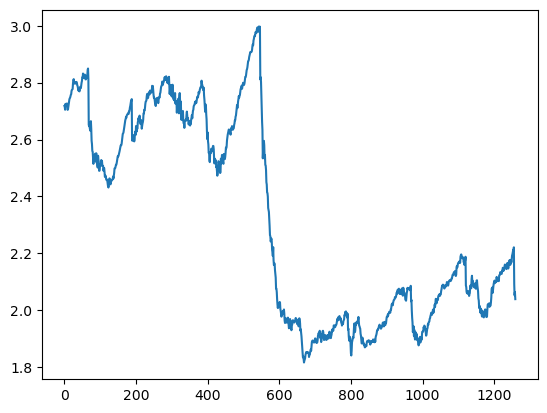

In [226]:
plt.plot(jnp.exp(y_meas/100.))

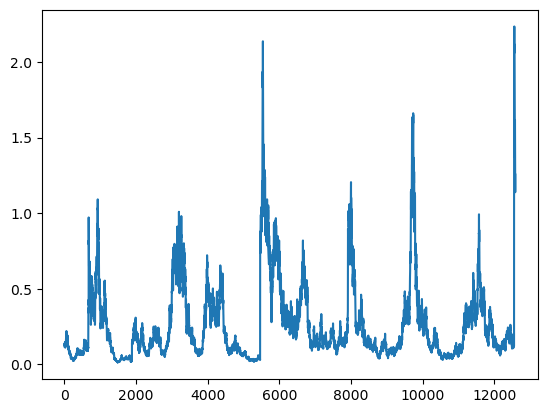

In [227]:
plt.plot(jnp.exp(x_state[1:,:,0].flatten()))
#plt.plot(x_state[1:,:,2].flatten())

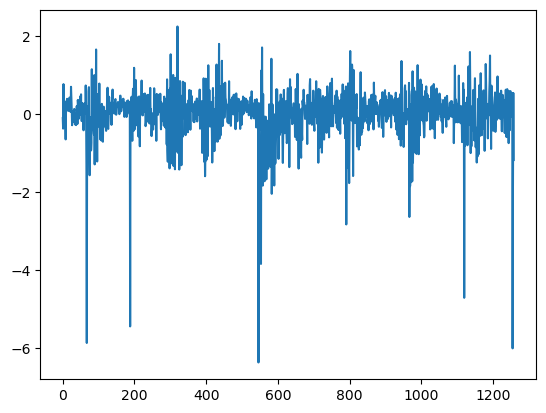

In [228]:
plt.plot(jnp.diff(y_meas))

In [229]:
def pf_mvn_objective_full(param_transformed, model, key, y_meas, resampler, n_particles=500):
    param = expou_transform.recover_param(param_transformed)
    param_dict = expou_transform.vec_to_dict(param)
    pf_mvn = pf.particle_filter(
            model=model,
            key=key,
            y_meas=y_meas,
            theta=param_dict,
            n_particles=n_particles,
            resampler=resampler,
        )
    negloglik = -pf_mvn["loglik"]
    return negloglik

In [280]:
loss_value, grads = jax.value_and_grad(pf_mvn_objective_full)(expou_transform.transform_param(my_expou_param), 
                                                              expou, jrandom.PRNGKey(5113), y_meas, resample_custom)


In [281]:
grads

Array([13.06914519,  0.83303216,  1.25745698, -1.41432523,  0.24979813,
        0.04634036, -1.78961257, -0.52904421, -0.47332131], dtype=float64)

In [1106]:
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

yf.pdr_override()
startdate = datetime.datetime(2019,1,1)
enddate = datetime.datetime(2024,1,1)

gspc = pdr.get_data_yahoo("^GSPC", start=startdate, end=enddate)

[*********************100%%**********************]  1 of 1 completed


In [1115]:
y_meas = jnp.log(jnp.array(gspc["Adj Close"]))
y_meas = y_meas *100/y_meas[0]

In [270]:
def fit(param, key, optimizer, iter):
    def step(carry, x):
        param = carry["param"]
        opt_state = carry["opt_state"]
        loss_value, grads = jax.value_and_grad(pf_mvn_objective_full)(param, expou, key, y_meas, resample_custom)
        updates, opt_state = optimizer.update(grads, opt_state, param)
        param = optax.apply_updates(param, updates)
        return {"param": param, "opt_state": opt_state}, {"param": param, "loss_value": loss_value, "grads": grads}
    
    last, full = jax.lax.scan(f=step, init={"param": param, "opt_state": optimizer.init(param)}, xs=jnp.array([key]*iter))
    return full


log_ret = jnp.diff(y_meas)
worst_prob = 0.03
worst_log_ret = log_ret[log_ret< jnp.quantile(log_ret, worst_prob)]

init_theta = {
    "alpha": 0.,
    "theta": jnp.log(jnp.var(log_ret)),
    "kappa": 0.,
    "sigma": 0.,
    "lambda": jsp.special.logit(worst_prob),
    "mu_x": jnp.mean(worst_log_ret),
    "sigma_x": jnp.log(jnp.std(worst_log_ret)),
    "mu_z": 0.,
    "rho": 0.
}

init_theta_vec = expou_transform.dict_to_vec(init_theta)

lr = 1e-1
scheduler = optax.exponential_decay(
    init_value=lr,
    transition_steps=1000,
    decay_rate=0.01)


In [282]:
test = fit(init_theta_vec, jrandom.PRNGKey(29781), optax.adam(learning_rate=scheduler), 200)

In [283]:
expou_transform.recover_param(test['param'][-1])

Array([ 0.15036847, -2.12034335,  0.02909027,  0.20128314,  0.00570023,
       -4.83028788,  1.28260574,  0.18392155, -0.45520771], dtype=float64)

In [291]:
my_hess = jax.hessian(pf_mvn_objective_full)(test['param'][-1], expou, jrandom.PRNGKey(29781), y_meas, resample_custom)


In [292]:
jnp.sqrt(jnp.diag(jnp.linalg.inv(my_hess)))

Array([0.01037627, 0.20853468, 0.27207778, 0.12868247, 0.3823897 ,
       0.30157893, 0.25142254, 0.39768176, 0.2797002 ], dtype=float64)

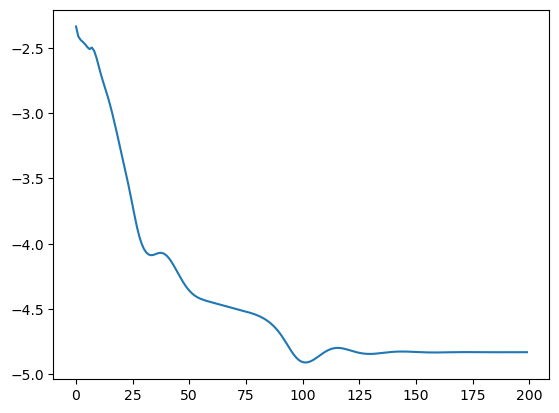

In [290]:
plt.plot(test['param'][:,5])

In [279]:
expou_transform.vec_to_dict(expou_transform.recover_param(test['param'][-1,:]) )

{'alpha': Array(0.14978082, dtype=float64),
 'theta': Array(-2.10572455, dtype=float64),
 'kappa': Array(0.02922261, dtype=float64),
 'sigma': Array(0.20173538, dtype=float64),
 'lambda': Array(0.00574046, dtype=float64),
 'mu_x': Array(-4.89804884, dtype=float64),
 'sigma_x': Array(1.28348875, dtype=float64),
 'mu_z': Array(0.17971504, dtype=float64),
 'rho': Array(-0.44939707, dtype=float64)}

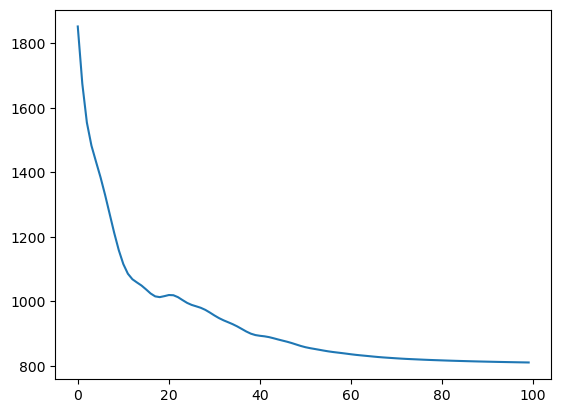

In [246]:
plt.plot(test['loss_value'])

In [646]:
jsp.special.expit(-4.525)

Array(0.01071858, dtype=float64, weak_type=True)

In [1130]:
pf_mvn = pf.particle_filter(
            model=expou,
            key=jrandom.PRNGKey(193),
            y_meas=y_meas,
            theta=expou_transform.vec_to_dict(expou_transform.recover_param(test['param'][-1,:])),
            n_particles=500,
            resampler=resample_custom,
            history=True
        )

In [1139]:
est_vol_mean.shape

(1257, 10)

In [1146]:
def norm_mean_var_weighted(x, logw):
    w = pf.utils.logw_to_prob(logw)
    x_mean = jnp.average(x, weights=w, axis=0)
    x_var = jnp.average((x-x_mean)**2, weights=w, axis=0)
    return x_mean, x_var

est_vol_mean, est_vol_var = jax.vmap(
    norm_mean_var_weighted, in_axes=(0,0))(pf_mvn["x_particles"][1:, ..., 0],
                      pf_mvn["logw"][1:, ...])
est_vol_sd = jnp.sqrt(est_vol_var)

est_vol_lower = est_vol_mean + jsp.stats.norm.ppf(q=0.025)*est_vol_sd
est_vol_upper = est_vol_mean + jsp.stats.norm.ppf(q=0.975)*est_vol_sd


<Axes: >

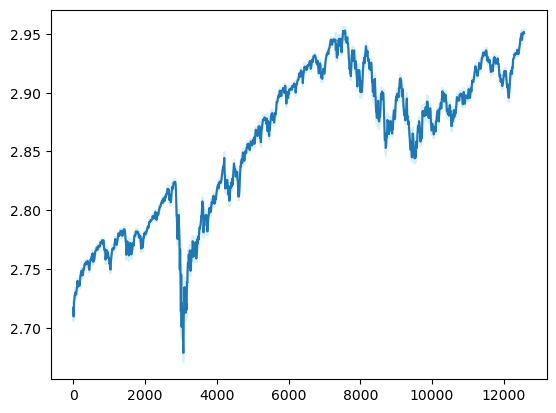

In [1144]:
sns.lineplot(jnp.exp(est_vol_lower.flatten()/100.),
             color = "skyblue", 
             alpha = 0.3)
sns.lineplot(jnp.exp(est_vol_upper.flatten()/100.),
             color = "skyblue", 
             alpha = 0.3)
sns.lineplot(jnp.exp(est_vol_mean.flatten()/100.))


<Axes: >

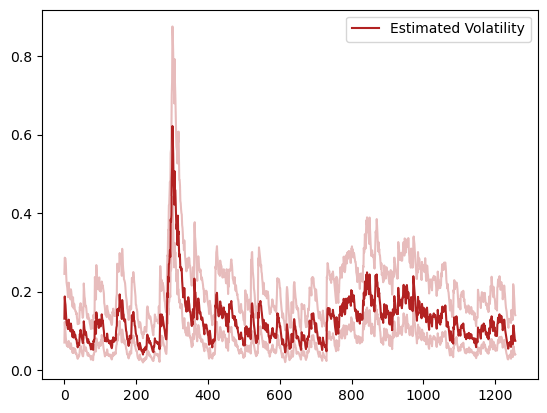

In [1147]:
sns.lineplot(jnp.exp(est_vol_lower/2)[:,-1], 
             color = "firebrick", 
             alpha = 0.3)
sns.lineplot(jnp.exp(est_vol_upper/2)[:,-1], 
             color = "firebrick", 
             alpha = 0.3)
sns.lineplot(jnp.exp(est_vol_mean/2)[:,-1], 
             color = "firebrick" ,
             label = "Estimated Volatility")

In [1152]:
est_vol_mean, est_vol_var = jax.vmap(
    norm_mean_var_weighted, in_axes=(0,0))(pf_mvn["x_particles"][1:, ..., 2],
                      pf_mvn["logw"][1:, ...])

<Axes: >

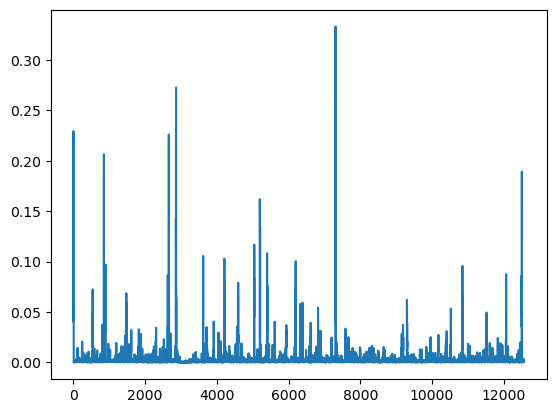

In [1156]:
sns.lineplot(est_vol_mean.flatten())